In [149]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from graphviz import Digraph
from IPython.display import Image
import seaborn as sns
from enum import Enum


In [150]:
pathfile = "./data/data_clean/data_tokens_18042024_coinmarket.csv"
df_tokens = pd.read_csv(pathfile,sep=";")

In [151]:
df_tokens['Precio USD'] = df_tokens['Precio USD'].str.replace(',', '.').astype(float)


In [152]:
columnas_float  = df_tokens.select_dtypes(include=['float64']).columns
df_float = df_tokens[columnas_float]
scaler = StandardScaler()
datos_normalizados = scaler.fit_transform(df_float)
df_normalizado = pd.DataFrame(datos_normalizados, columns=columnas_float)
df_tokens = pd.concat([df_tokens.drop(columns=columnas_float), df_normalizado], axis=1)


In [153]:
df_tokens[columnas_float].head()

top       1h%      24h%       7d%  Volumen (24h) USD  \
0 -0.078013  0.212809 -0.552218 -0.030356          -0.108725   
1  0.591805  0.223451 -2.945591 -0.029728          -0.116018   
2 -0.795009  0.063826 -0.187754 -0.030204          -0.113429   
3 -0.838255 -0.066003 -0.167777 -0.029330          -0.108202   
4  0.153450 -0.332045 -0.200910 -0.029571          -0.113952   

   Volumen (24h) Tokens  ACC. CIRCULACION  CAP. USD  Precio USD  
0             -0.045951         -0.076719 -0.029871   -0.093436  
1             -0.045771         -0.075840 -0.029870   -0.093338  
2             -0.045953         -0.076718 -0.029869   -0.093430  
3             -0.045954         -0.076719 -0.029868   -0.084741  
4             -0.045954         -0.076716 -0.029835   -0.086681

In [154]:
df_tokens.head()

TOKENS  AI  GAMING  MEMES   Symbol  Alameda Research  \
0          Trex20   0       1      0     TX20                 0   
1          Sponge   0       0      1  $SPONGE                 0   
2  Heroes Chained   0       1      0      HEC                 0   
3         Crypton   0       1      0      CRP                 0   
4         Ring AI   1       0      0     RING                 0   

   Arrington XRP Capital  Binance Labs  Blockchain Capital  CMS Holdings  ...  \
0                      0             0                   0             0  ...   
1                      0             0                   0             0  ...   
2                      0             0                   0             0  ...   
3                      0             0                   0             0  ...   
4                      0             0                   0             0  ...   

   OTHER       top       1h%      24h%       7d%  Volumen (24h) USD  \
0      0 -0.078013  0.212809 -0.552218 -0.030356          -0.108725   
1      1  0.591805  0.223451 -2.945591 -0.029728          -0.116018   
2      0 -0.795009  0.063826 -0.187754 -0.030204          -0.113429   
3      1 -0.838255 -0.066003 -0.167777 -0.029330          -0.108202   
4      1  0.153450 -0.332045 -0.200910 -0.029571          -0.113952   

   Volumen (24h) Tokens  ACC. CIRCULACION  CAP. USD  Precio USD  
0             -0.045951         -0.076719 -0.029871   -0.093436  
1             -0.045771         -0.075840 -0.029870   -0.093338  
2             -0.045953         -0.076718 -0.029869   -0.093430  
3             -0.045954         -0.076719 -0.029868   -0.084741  
4             -0.045954         -0.076716 -0.029835   -0.086681  

[5 rows x 40 columns]

<Axes: >

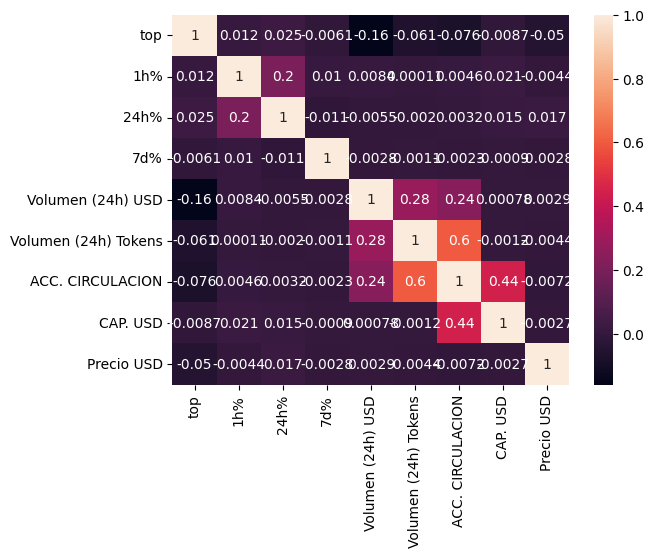

In [155]:
sns.heatmap(df_tokens[columnas_float].corr(), annot=True)

In [156]:
class KIND_NODE(Enum):
    PORTFOLIO = "portfolio"
    ECOSYSTEM = "ecosystem"
    TOKEN_CATEGORY_AI = "token_category_ai"
    TOKEN_CATEGORY_GAMING = "token_category_gaming"
    TOKEN_CATEGORY_MEME = "token_category_meme"
    TOKEN_CATEGORY_AI_GAMING = "token_category_ai_gaming"
    TOKEN_CATEGORY_AI_MEME = "token_category_ai_meme"
    TOKEN_CATEGORY_GAMING_MEME = "token_category_gaming_meme"
    TOKEN_CATEGORY_AI_GAMING_MEME = "token_category_ai_gaming_meme"

class KIND_RELATION(Enum):
    TOKEN_TO_PORTFOLIO = "token_to_portfolio"
    TOKEN_TO_ECOSYSTEM = "token_to_ecosystem"
    TOKEN_TO_TOKEN = "token_to_token"


In [157]:
class Graph_:
    def __init__(self):
        self.nodes = {}
        self.relations = {}
    def add_node(self,id,kind,data):
        self.nodes[id]={"kind":kind,"data":data}
    def add_relation(self, id, v_id, kind_relation, function):
        if id not in self.relations:
            self.relations[id] = []
        existing_edges = sum(1 for relation in self.relations[id] if relation[0] == v_id)
        if function > 40 and existing_edges < 5:
            self.relations[id].append([v_id, kind_relation, function])
    def drop_relation_duplicated(self):
        for id in self.relations:
            self.relations[id] = [list(item) for item in set(tuple(relation) for relation in self.relations[id])]


    def get_nodes(self):
        return self.nodes
    def get_relations(self):
        return self.relations

In [158]:
class GraphBuilder:
    def __init__(self):
        self.graph = Graph_()
    def add_node(self,id,kind,data):
        self.graph.add_node(id,kind,data)
    def add_relation(self,id,v_id,kind_relation):
        self.graph.add_relation(id,v_id,kind_relation,self.select_function(id,v_id,kind_relation))
    def select_function(self,id,v_id,kind_relation):
        if kind_relation == KIND_RELATION.TOKEN_TO_PORTFOLIO:
            return 100
        elif kind_relation == KIND_RELATION.TOKEN_TO_ECOSYSTEM:
            return 100
        elif kind_relation == KIND_RELATION.TOKEN_TO_TOKEN:
            data_id=self.graph.get_nodes()[id]["data"]

            valores_id = [data_id[clave] for clave in columnas_float]
            data_v=self.graph.get_nodes()[v_id]["data"]

            valores_v = [data_v[clave] for clave in columnas_float]
            datos = valores_id + valores_v
            norma_euclidiana = np.linalg.norm(datos)
            return norma_euclidiana
    def get_graph(self):
        return self.graph

In [159]:
class GraphvizBuilder:
    def __init__(self,graph):
        self.graph = graph
        self.graph.drop_relation_duplicated()

    def build_node(self,key,value):
        if value["kind"] == KIND_NODE.TOKEN_CATEGORY_GAMING:
            self.dot.node(key,color="darkgoldenrod1",shape="circle",fontcolor="black",style="filled")
        elif value["kind"] == KIND_NODE.TOKEN_CATEGORY_AI:
            self.dot.node(key,color="coral",shape="circle",fontcolor="black",style="filled")
        elif value["kind"] == KIND_NODE.TOKEN_CATEGORY_MEME:
            self.dot.node(key,color="seagreen",shape="circle",fontcolor="black",style="filled")
        elif value["kind"] == KIND_NODE.PORTFOLIO:
            self.dot.node(key,color="olivedrab1",shape="circle",fontcolor="black",style="filled",height="6",width="6", fontsize="80")
        elif value["kind"] == KIND_NODE.ECOSYSTEM:
            self.dot.node(key,color="slateblue1",shape="circle",fontcolor="black",style="filled",height="4",width="4",fontsize="80")
        elif value["kind"] == KIND_NODE.TOKEN_CATEGORY_AI_GAMING:
            self.dot.node(key,color="mediumaquamarine",shape="circle",fontcolor="black",style="filled")
        elif value["kind"] == KIND_NODE.TOKEN_CATEGORY_AI_MEME:
            self.dot.node(key,color="deeppink",shape="circle",fontcolor="black",style="filled")
        elif value["kind"] == KIND_NODE.TOKEN_CATEGORY_GAMING_MEME:
            self.dot.node(key,color="crimson",shape="circle",fontcolor="black",style="filled")
        elif value["kind"] == KIND_NODE.TOKEN_CATEGORY_AI_GAMING_MEME:
            self.dot.node(key,color="purple",shape="circle",fontcolor="black",style="filled")

    def build_relation(self,key,value):
       for data in value :
            v_id,kind,ponderation = data
            if kind == KIND_RELATION.TOKEN_TO_PORTFOLIO:
                self.dot.edge(key,v_id,color="green",weight=str(int(ponderation)))
            elif kind == KIND_RELATION.TOKEN_TO_ECOSYSTEM:
                self.dot.edge(key,v_id,color="orange",weight=str(int(ponderation)))
            elif kind == KIND_RELATION.TOKEN_TO_TOKEN:
                self.dot.edge(key,v_id,color="pink",weight=str(int(ponderation)))


    def build(self):
        self.dot = Digraph()
        for key,value in self.graph.get_nodes().items():
            self.build_node(key,value)
        for key,value in self.graph.get_relations().items():
            self.build_relation(key,value)
        return self.dot


In [160]:
tokens = df_tokens.to_dict(orient="records")

In [161]:
builder_litle = GraphBuilder()

In [162]:
for token in tokens[:200]:
    if token["AI"] == 1 and token["GAMING"] == 0 and token["MEMES"] == 0:
        builder_litle.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_AI, token)
    elif token["AI"] == 0 and token["GAMING"] == 1 and token["MEMES"] == 0:
        builder_litle.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_GAMING, token)
    elif token["AI"] == 0 and token["GAMING"] == 0 and token["MEMES"] == 1:
        builder_litle.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_MEME, token)
    elif token["AI"] == 1 and token["GAMING"] == 1 and token["MEMES"] == 0:
        builder_litle.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_AI_GAMING, token)
    elif token["AI"] == 1 and token["GAMING"] == 0 and token["MEMES"] == 1:
        builder_litle.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_AI_MEME, token)
    elif token["AI"] == 0 and token["GAMING"] == 1 and token["MEMES"] == 1:
        builder_litle.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_GAMING_MEME, token)
    elif token["AI"] == 1 and token["GAMING"] == 1 and token["MEMES"] == 1:
        builder_litle.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_AI_GAMING_MEME, token)

In [163]:
porfolio_list=list(df_tokens.columns)[5:25]
for portfolio in porfolio_list:
    builder_litle.add_node(portfolio, KIND_NODE.PORTFOLIO, {"name": portfolio})

ecosystem_list = list(df_tokens.columns)[25:31]
for ecosystem in ecosystem_list:
    builder_litle.add_node(ecosystem, KIND_NODE.ECOSYSTEM, {"name": ecosystem})

In [164]:
for token in tokens[:200]:
    for portfolio in porfolio_list:
        if token[portfolio] == 1:
            builder_litle.add_relation(token["TOKENS"],portfolio,KIND_RELATION.TOKEN_TO_PORTFOLIO)
    for ecosystem in ecosystem_list:
        if token[ecosystem] == 1:
            builder_litle.add_relation(token["TOKENS"],ecosystem,KIND_RELATION.TOKEN_TO_ECOSYSTEM)
    for token_ in tokens[:200]:
        if token["TOKENS"] != token_["TOKENS"] and token["AI"] == 1 and token_["AI"] == 1:
            builder_litle.add_relation(token["TOKENS"],token_["TOKENS"],KIND_RELATION.TOKEN_TO_TOKEN)
        elif token["TOKENS"] != token_["TOKENS"] and token["GAMING"] == 1 and token_["GAMING"] == 1:
            builder_litle.add_relation(token["TOKENS"],token_["TOKENS"], KIND_RELATION.TOKEN_TO_TOKEN)
        elif token["TOKENS"] != token_["TOKENS"] and token["MEMES"] == 1 and token_["MEMES"] == 1:
            builder_litle.add_relation(token["TOKENS"],token_["TOKENS"],KIND_RELATION.TOKEN_TO_TOKEN)


In [165]:
dot_litle =  GraphvizBuilder(builder_litle.get_graph()).build()
dot_litle.attr(layout='sfdp',beautify="true" ,splines='curved', concentrate="true",overlap='false',size="30,30",bgcolor="black")
dot_litle.save("graph_litle.dot")

'graph_litle.dot'

In [166]:
dot_litle.render("dot_litle", format='png', cleanup=True)

'dot_litle.png'

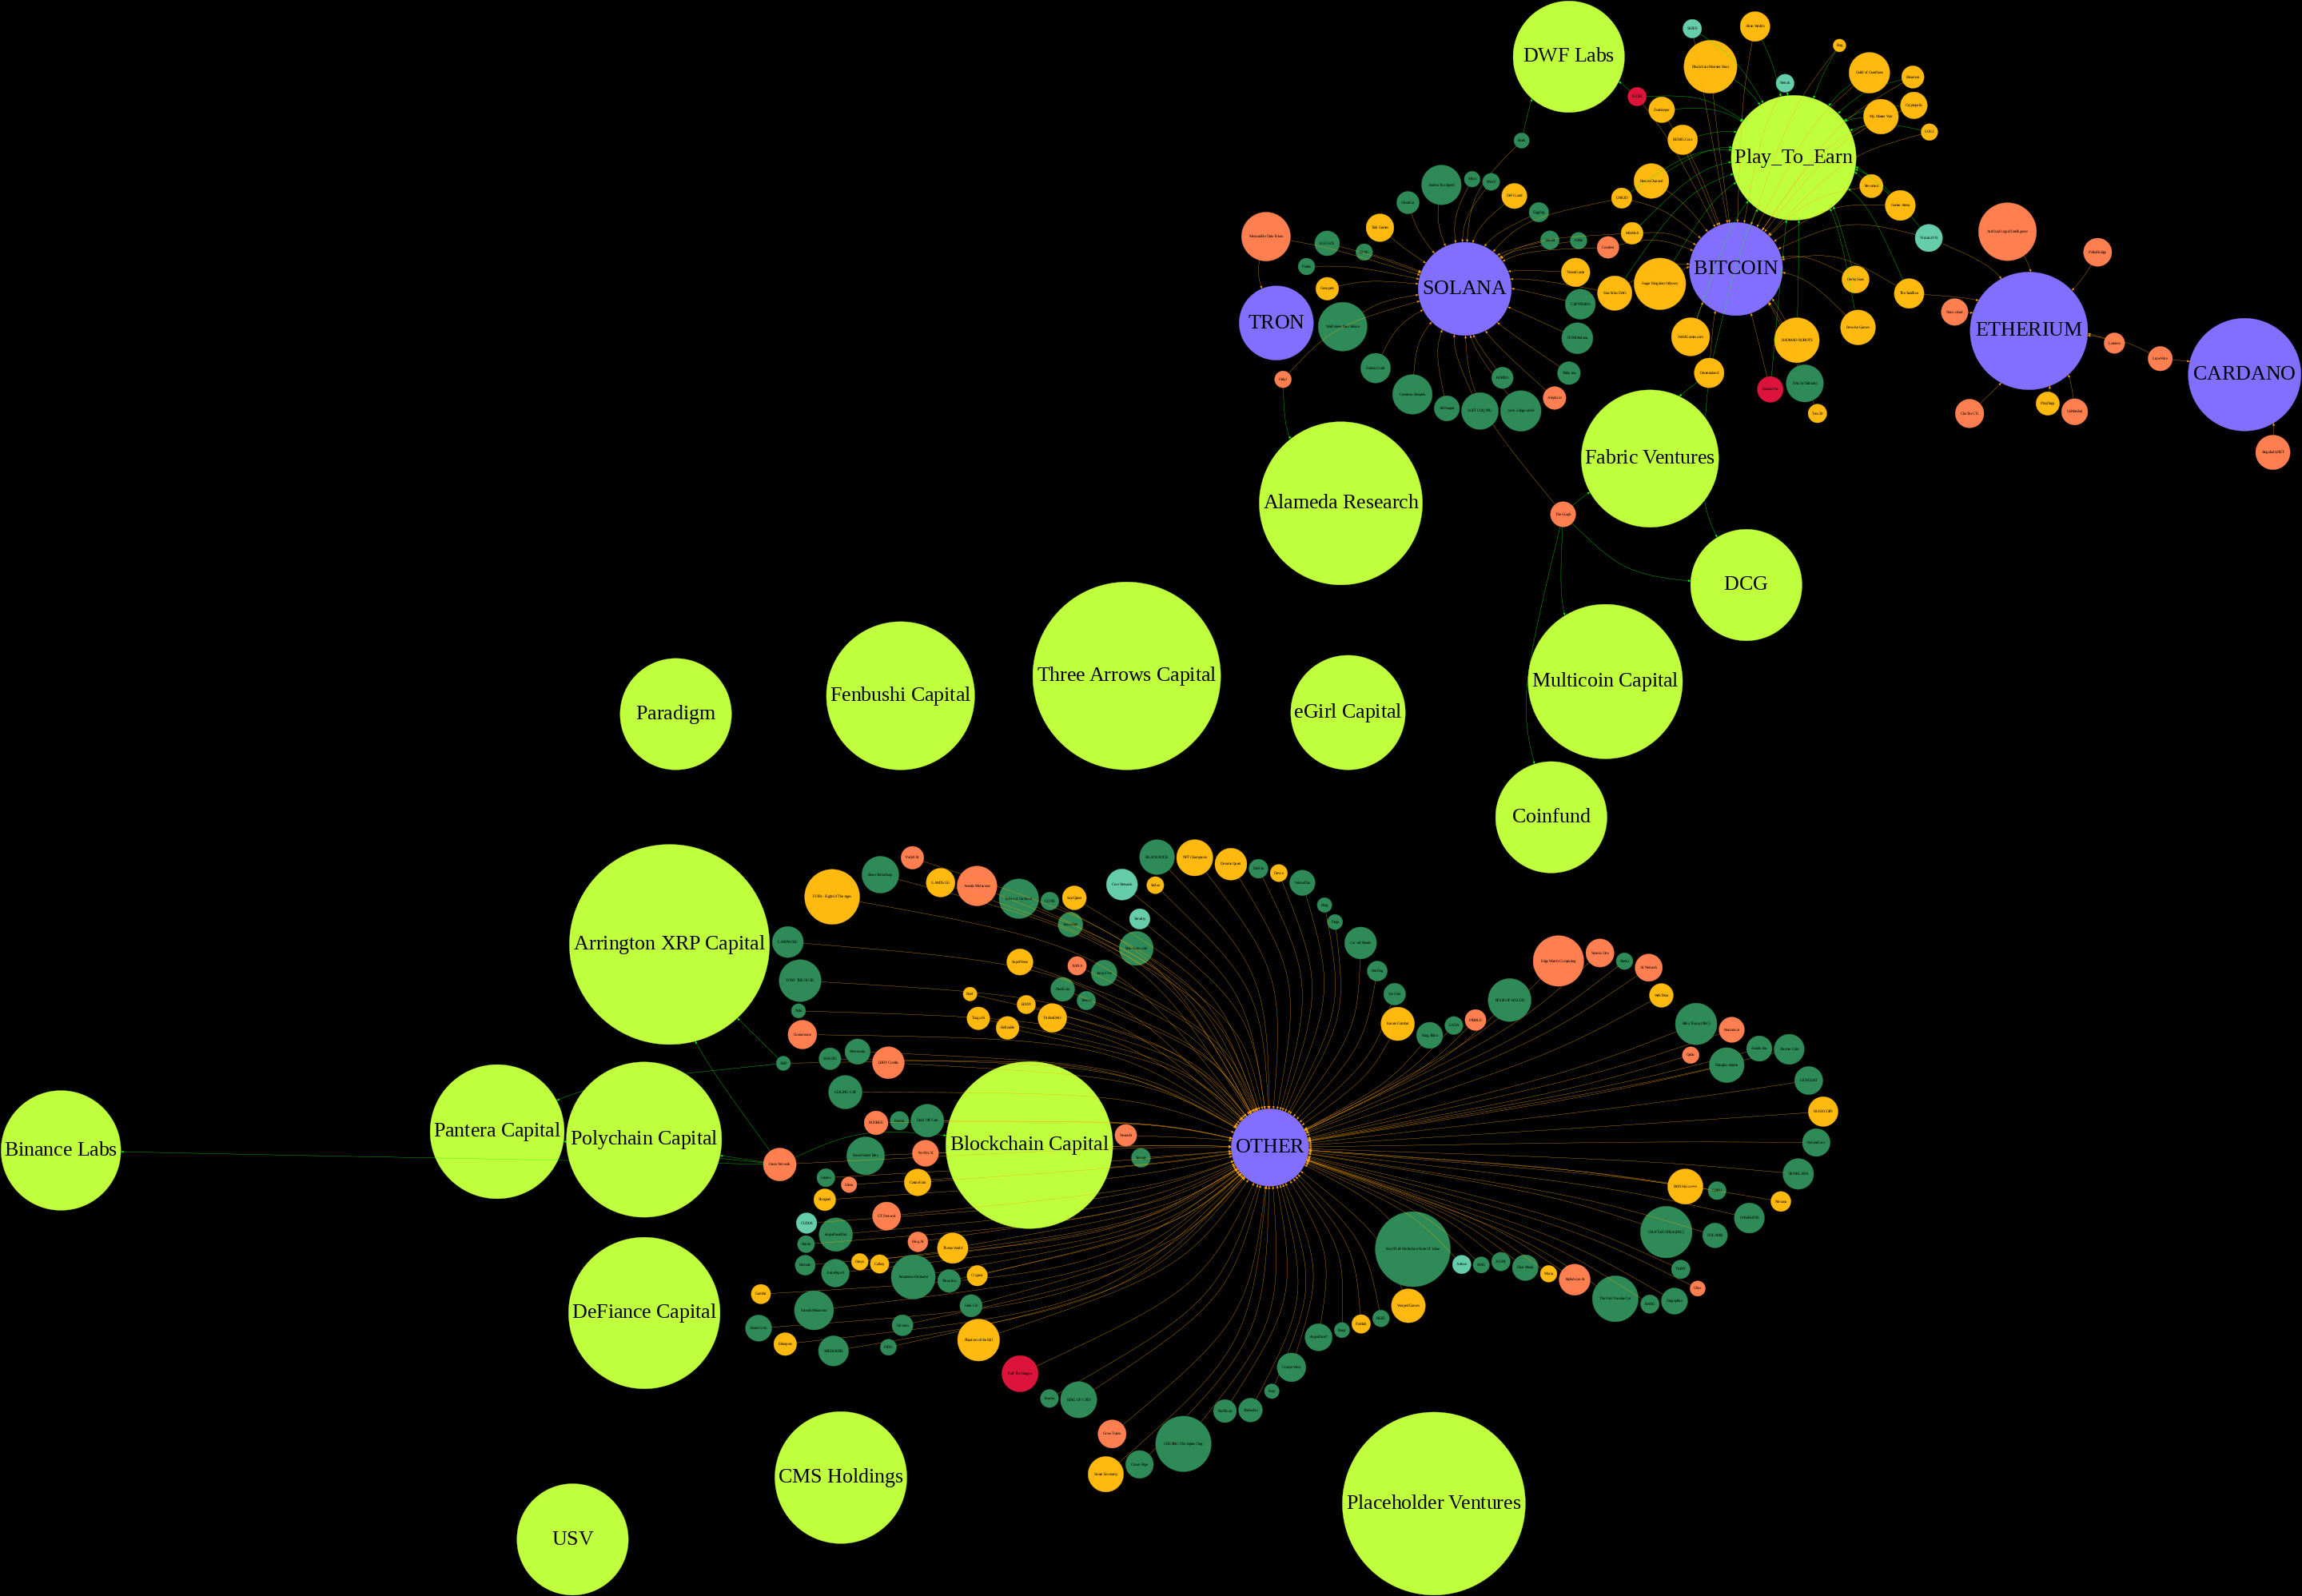

In [167]:
Image("dot_litle.png")

In [168]:
builder = GraphBuilder()

In [169]:
for token in tokens:
    if token["AI"] == 1 and token["GAMING"] == 0 and token["MEMES"] == 0:
        builder.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_AI, token)
    elif token["AI"] == 0 and token["GAMING"] == 1 and token["MEMES"] == 0:
        builder.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_GAMING, token)
    elif token["AI"] == 0 and token["GAMING"] == 0 and token["MEMES"] == 1:
        builder.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_MEME, token)
    elif token["AI"] == 1 and token["GAMING"] == 1 and token["MEMES"] == 0:
        builder.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_AI_GAMING, token)
    elif token["AI"] == 1 and token["GAMING"] == 0 and token["MEMES"] == 1:
        builder.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_AI_MEME, token)
    elif token["AI"] == 0 and token["GAMING"] == 1 and token["MEMES"] == 1:
        builder.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_GAMING_MEME, token)
    elif token["AI"] == 1 and token["GAMING"] == 1 and token["MEMES"] == 1:
        builder.add_node(token["TOKENS"], KIND_NODE.TOKEN_CATEGORY_AI_GAMING_MEME, token)


In [170]:
list(df_tokens.columns)[25:31]

['BITCOIN', 'CARDANO', 'ETHERIUM', 'SOLANA', 'TRON', 'OTHER']

In [171]:
porfolio_list=list(df_tokens.columns)[5:25]
for portfolio in porfolio_list:
    builder.add_node(portfolio, KIND_NODE.PORTFOLIO, {"name": portfolio})

ecosystem_list = list(df_tokens.columns)[25:31]
for ecosystem in ecosystem_list:
    builder.add_node(ecosystem, KIND_NODE.ECOSYSTEM, {"name": ecosystem})

In [172]:
for token in tokens:
    for portfolio in porfolio_list:
        if token[portfolio] == 1:
            builder.add_relation(token["TOKENS"],portfolio,KIND_RELATION.TOKEN_TO_PORTFOLIO)
    for ecosystem in ecosystem_list:
        if token[ecosystem] == 1:
            builder.add_relation(token["TOKENS"],ecosystem,KIND_RELATION.TOKEN_TO_ECOSYSTEM)
    for token_ in tokens:
        if token["TOKENS"] != token_["TOKENS"] and token["AI"] == 1 and token_["AI"] == 1:
            builder.add_relation(token["TOKENS"],token_["TOKENS"],KIND_RELATION.TOKEN_TO_TOKEN)
        elif token["TOKENS"] != token_["TOKENS"] and token["GAMING"] == 1 and token_["GAMING"] == 1:
            builder.add_relation(token["TOKENS"],token_["TOKENS"], KIND_RELATION.TOKEN_TO_TOKEN)
        elif token["TOKENS"] != token_["TOKENS"] and token["MEMES"] == 1 and token_["MEMES"] == 1:
            builder.add_relation(token["TOKENS"],token_["TOKENS"],KIND_RELATION.TOKEN_TO_TOKEN)



In [173]:
dot = GraphvizBuilder(builder.get_graph()).build()
dot.attr(layout='neato' ,splines='curved', concentrate="true",overlap='false',size="30,30",bgcolor="black")
dot.save("graph.dot")

'graph.dot'

In [174]:
dot.render("graph", format='png', cleanup=True)

'graph.png'

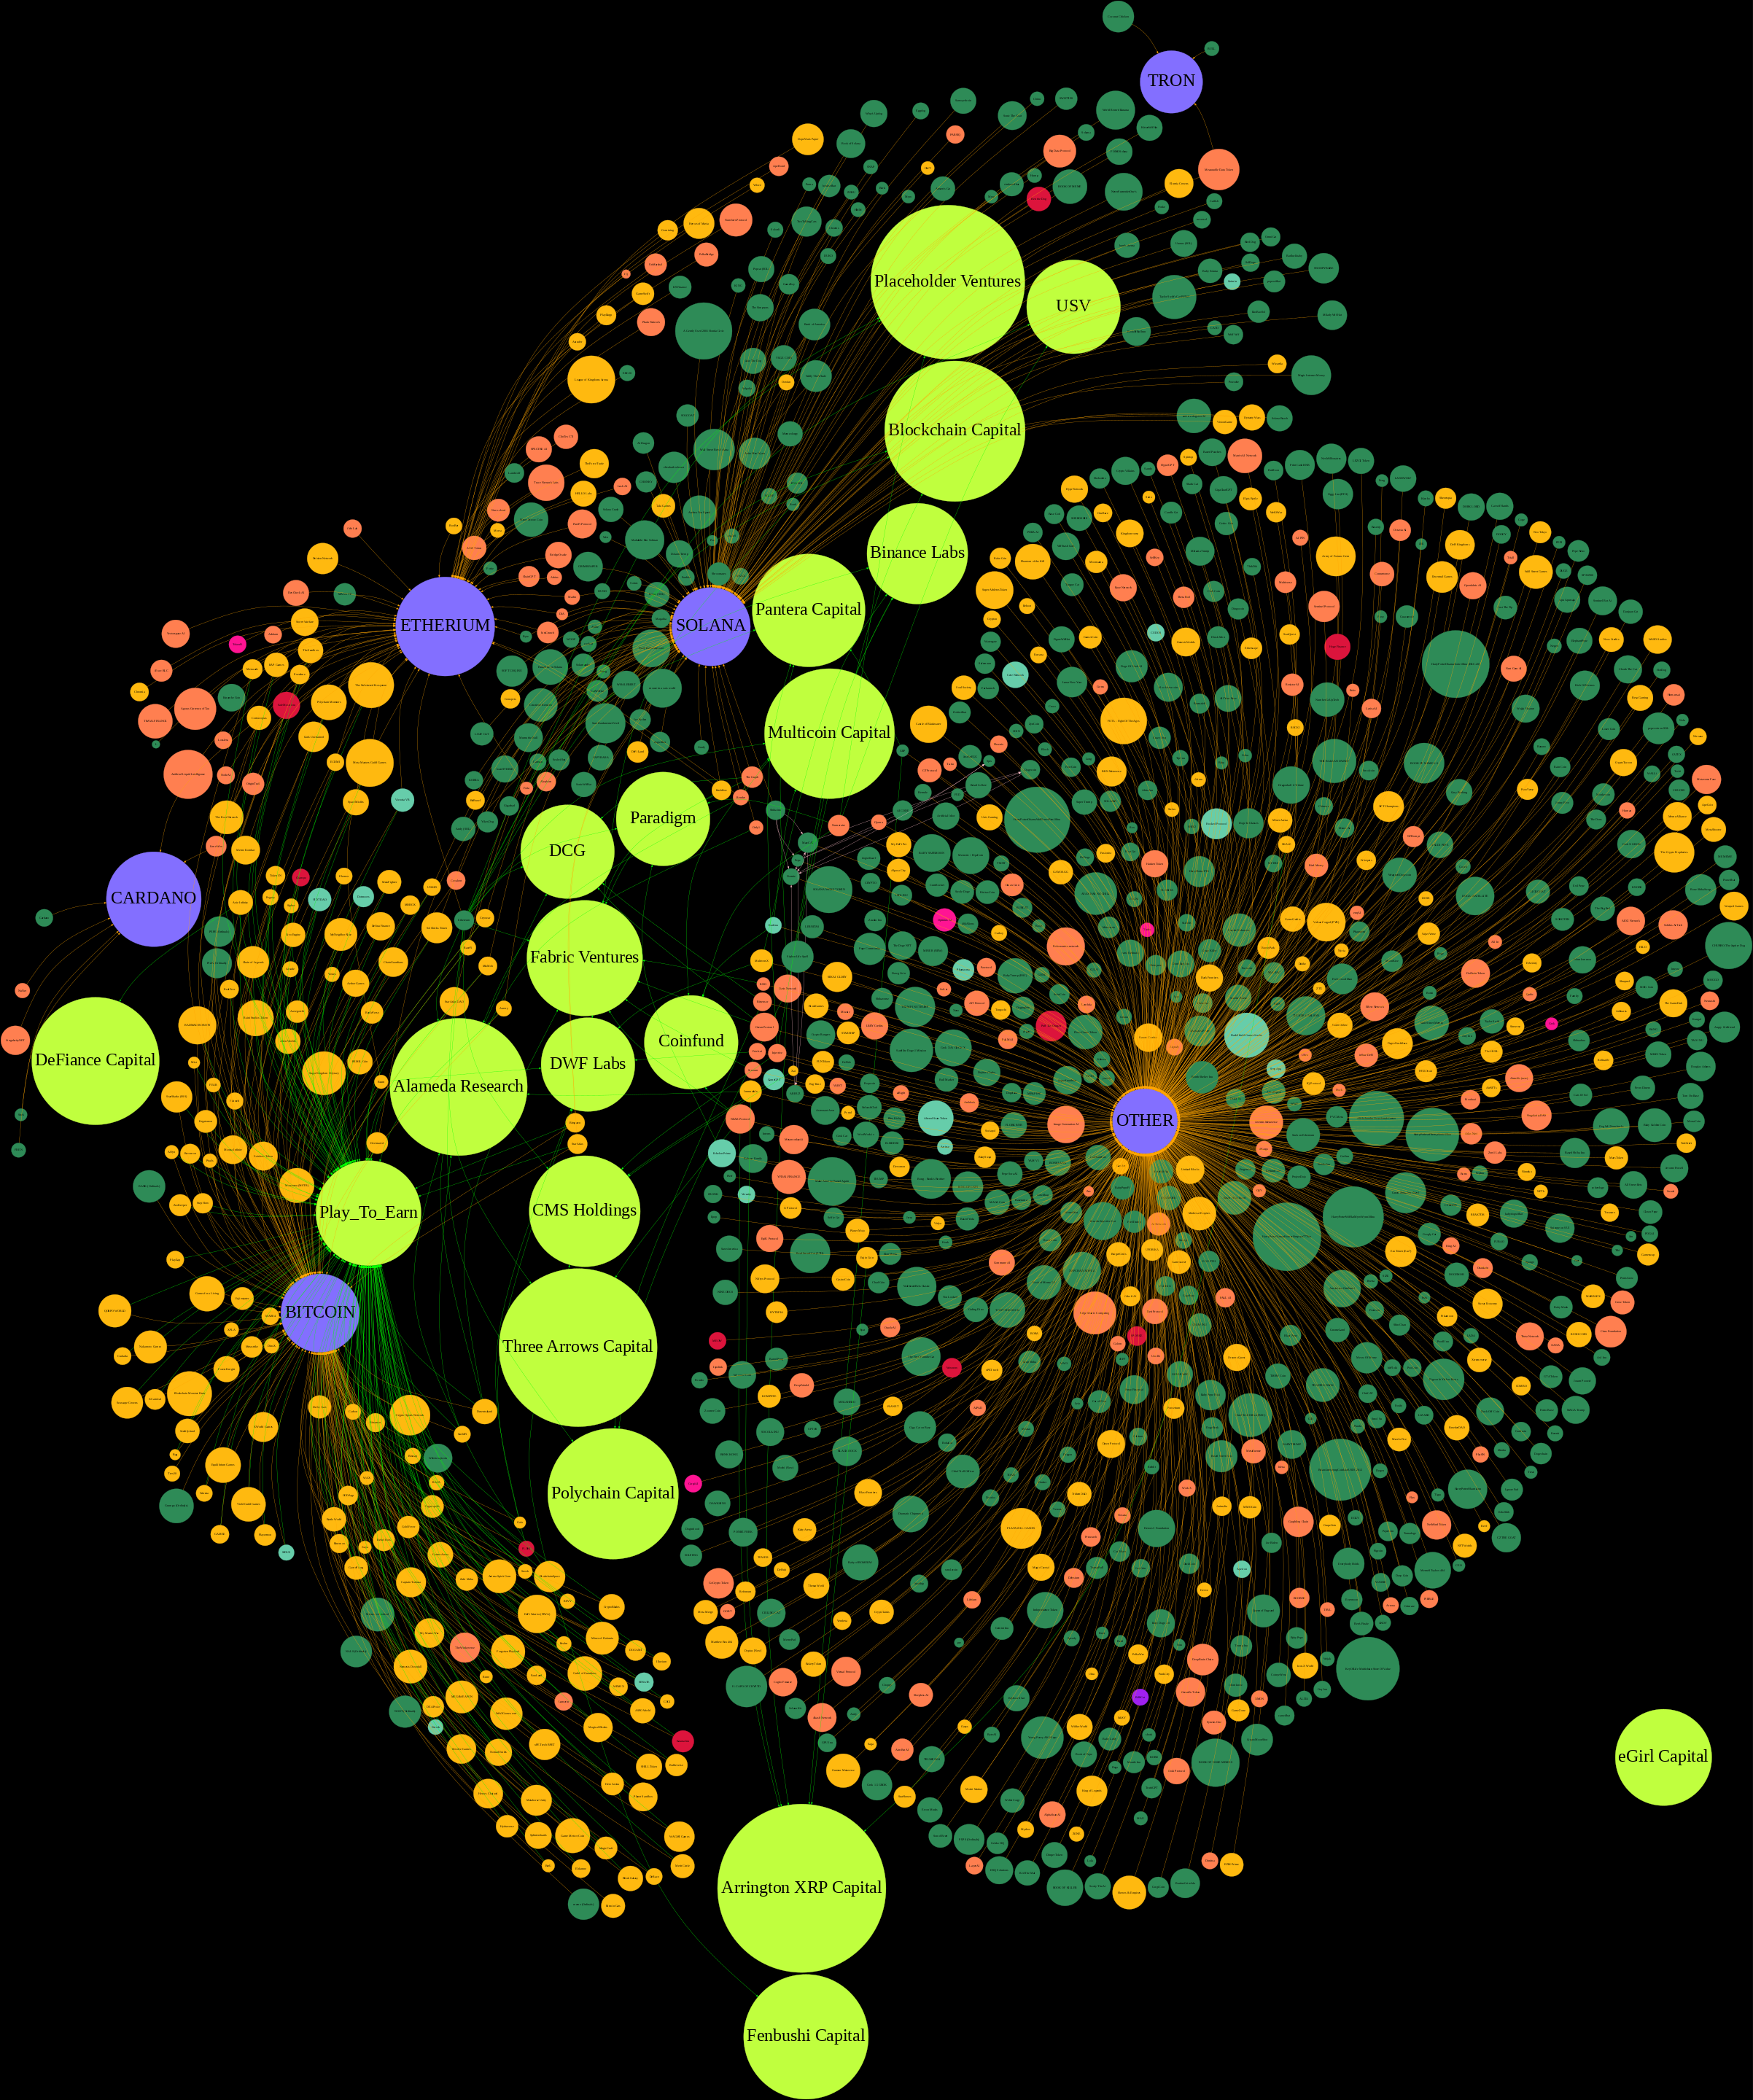

In [175]:
Image("graph.png")